In [1]:
#Importing the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import absolute, mean, std
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, RepeatedKFold, train_test_split
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing the cleaned data that was exported from Part 1
movies = pd.read_csv('Cleaned_Movies.csv')

#Cleaning nas.
movies = movies.dropna()

#Deleting the first column as it is just a number column
del movies['Unnamed: 0']

#Viewing the data frame head
movies.head()

,genres,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,Musical,Mystery,News,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,Action,Color,Tim Burton,153,126,13000,390,Vincent Schiavelli,920,162831698,...,0,0,0,0,0,0,0,0,0,0
1,Action,Color,Jon Hess,19,87,29,147,Ian Gomez,683,1200000,...,0,0,0,0,0,0,0,0,0,0
2,Action,Color,Tony Jaa,110,110,0,7,Petchtai Wongkamlao,64,102055,...,0,0,0,0,0,0,0,0,0,0
3,Action,Color,RZA,208,107,561,353,RZA,746,15608545,...,0,0,0,0,0,0,0,0,0,0
4,Action,Color,Joel Schumacher,183,125,541,409,Vivica A. Fox,920,107285004,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Viewing the sums of all the numerical columns
numbers = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_df = movies.select_dtypes(include = numbers)
num_df.sum()

num_critic_for_reviews       6.024170e+05
duration                     4.026650e+05
director_facebook_likes      2.972990e+06
actor_3_facebook_likes       2.757764e+06
actor_1_facebook_likes       2.804675e+07
gross                        1.892406e+11
num_voted_users              3.826189e+08
cast_total_facebook_likes    4.160418e+07
facenumber_in_poster         5.064000e+03
num_user_for_reviews         1.209215e+06
budget                       1.550602e+11
title_year                   7.320615e+06
actor_2_facebook_likes       7.251143e+06
imdb_score.x                 2.362360e+04
aspect_ratio                 7.707770e+03
movie_facebook_likes         3.333503e+07
imdb_score.y                 2.347000e+04
Action                       9.240000e+02
Adventure                    7.520000e+02
Animation                    1.940000e+02
Biography                    2.370000e+02
Comedy                       1.442000e+03
Crime                        6.920000e+02
Documentary                  4.500

In [4]:
#It looks like there are no values under News and Short movies, so these columns will be removed.
del movies['News']
del movies['Short']

In [5]:
del movies['imdb_score.y']
movies['imdb_score'] = movies['imdb_score.x']
del movies['imdb_score.x']

In [6]:
movies = pd.get_dummies(movies, columns = ['content_rating'], drop_first=True)

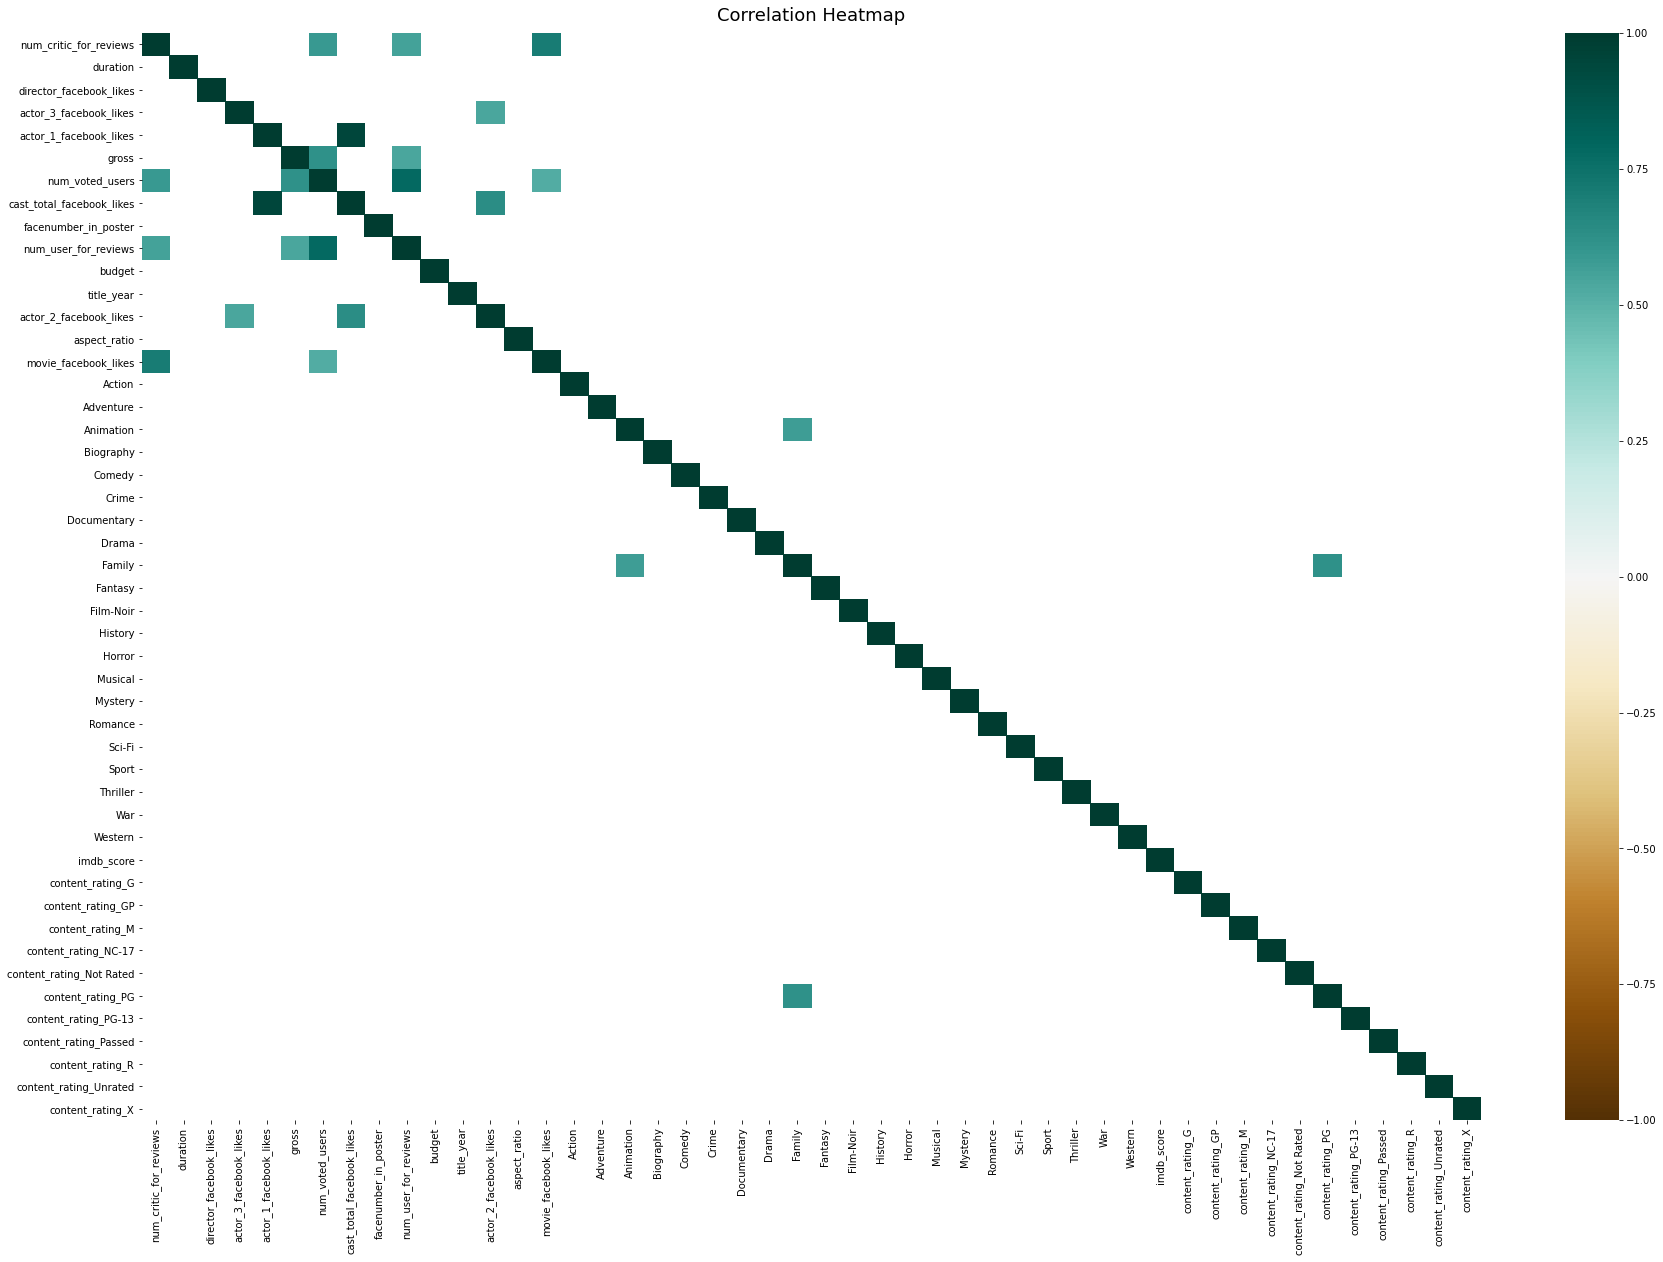

In [7]:
#Viewing the correlated variables once more to determine which variables are correlated
#Only correlations above 0.5 will be displayed to indicate what variables are causing multicollinearity.
#These variables will be removed before the EDA, feature selection, and model building steps.

plt.figure(figsize = (30, 20))
heatmap = sns.heatmap(movies.corr()[movies.corr() >= 0.5], vmin = -1, vmax = 1, cmap = 'BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad = 12);

In [8]:
#Color, languages, and plot keywords will be removed as these features will be of no use to our analysis.
#Color and language are overwhelmingly of one element, and keywords are much too different to be useful
#for building a predictive analytic model.

del movies['color']
del movies['language']
del movies['plot_keywords']

In [9]:
#In addition, variables that were shown to have high correlations with other variables will be deleted, such as number 
#of users who voted on the movie in IMDb, number of user reviews, and number of critic reviews

del movies['num_voted_users']
del movies['num_user_for_reviews']
del movies['num_critic_for_reviews']

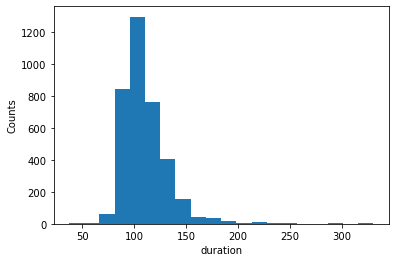

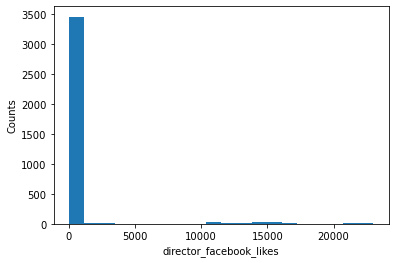

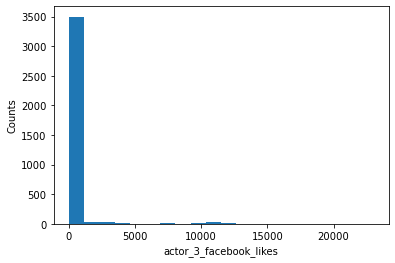

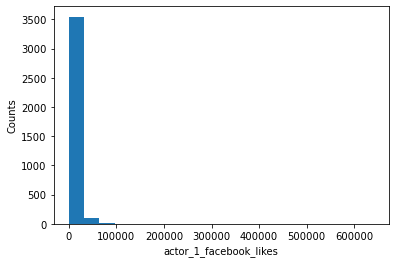

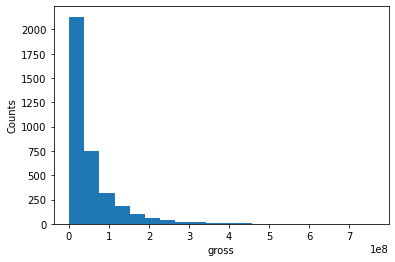

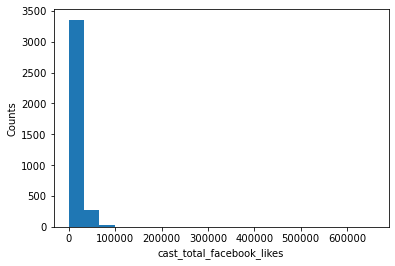

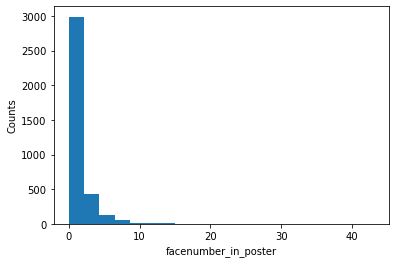

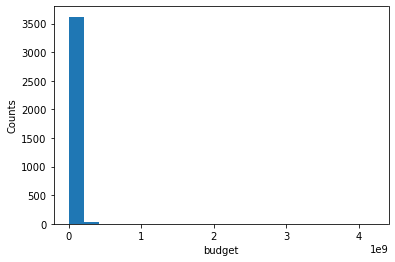

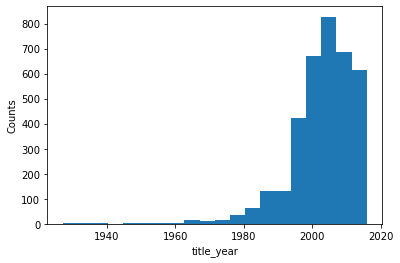

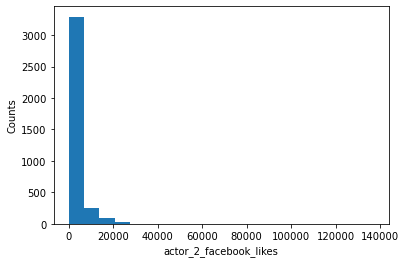

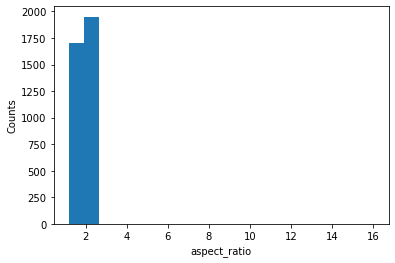

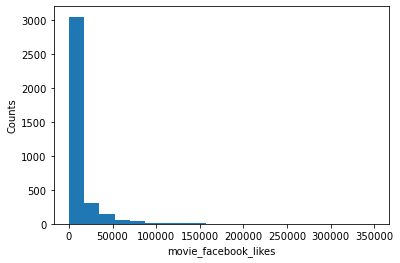

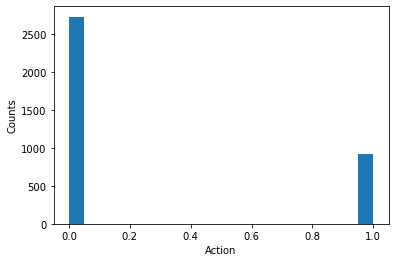

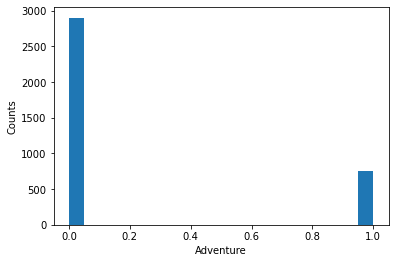

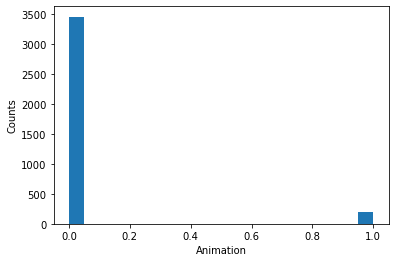

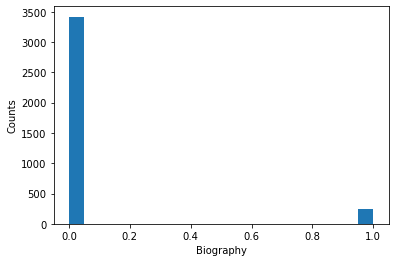

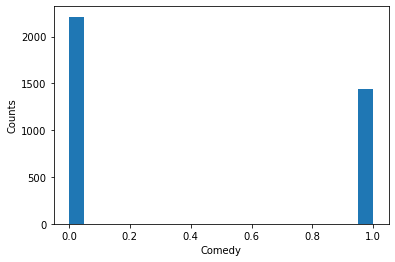

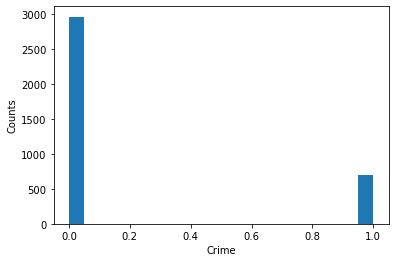

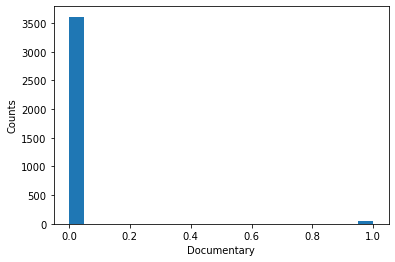

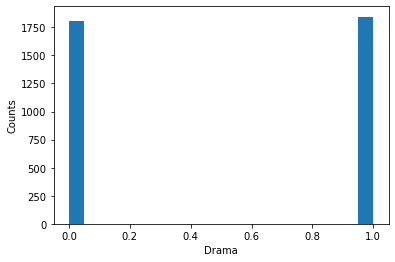

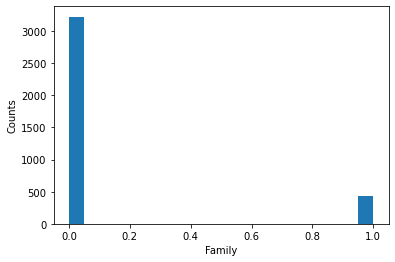

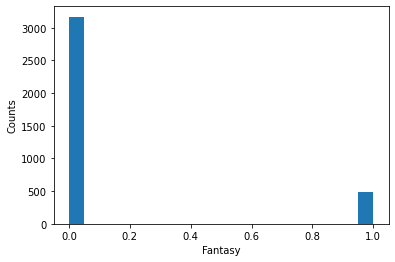

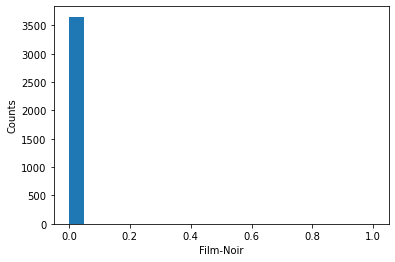

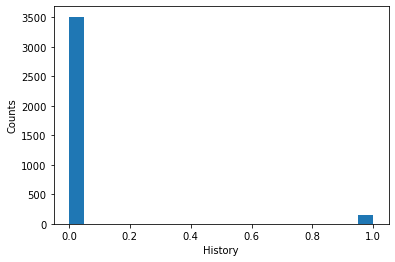

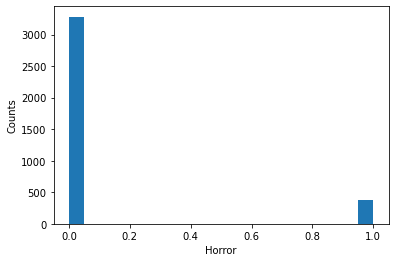

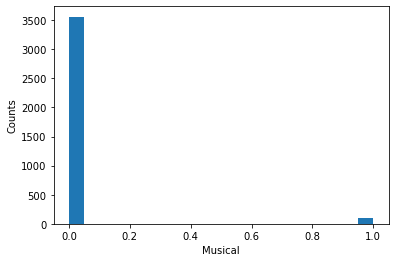

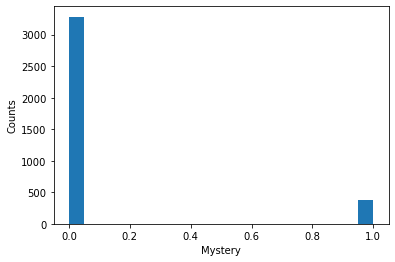

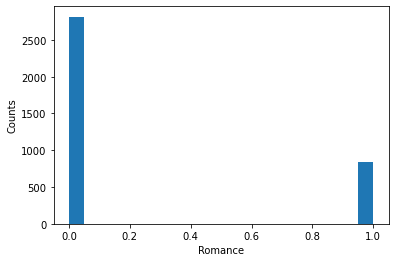

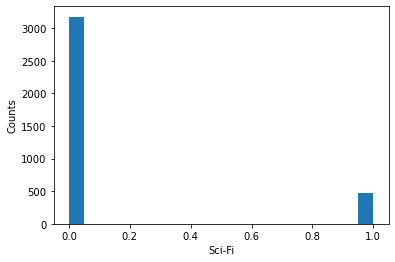

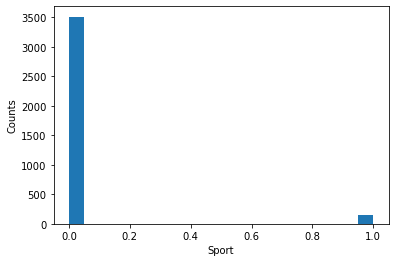

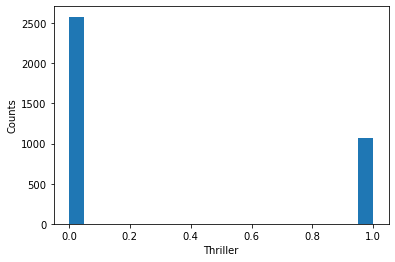

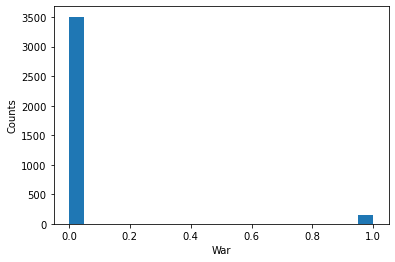

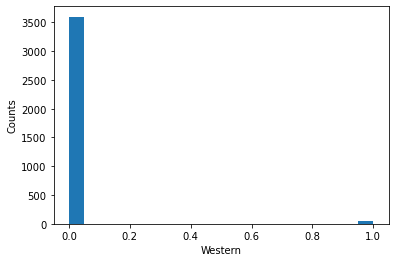

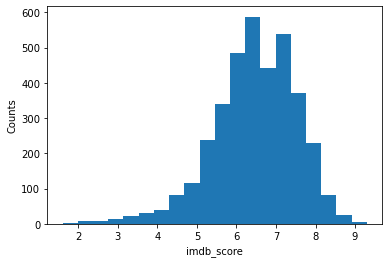

In [10]:
#Generating histograms of the numerical variables
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = movies.select_dtypes(include = numerics)

for i in range(newdf.shape[1]):
    plt.hist(newdf[newdf.columns[i]], bins = 20)
    plt.xlabel(newdf.columns[i])
    plt.ylabel('Counts')
    plt.show()

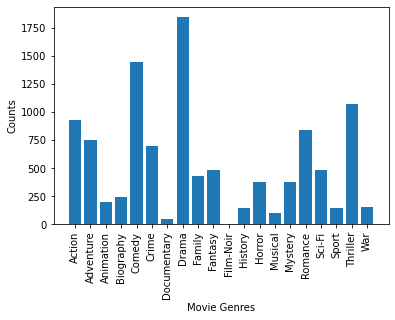

In [11]:
#Generating a bar chart of the movie genres

genre_names = movies.columns[20:40]
sums = [movies[genre].sum() for genre in genre_names]

plt.bar(genre_names, sums)
plt.xlabel('Movie Genres')
plt.ylabel('Counts')
plt.xticks(rotation = 90)
plt.show()

#It appears that Drama, Comedy, Thriller, Action, and Romance are the top 5 movie genres of all time

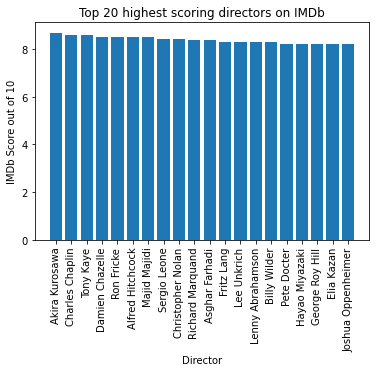

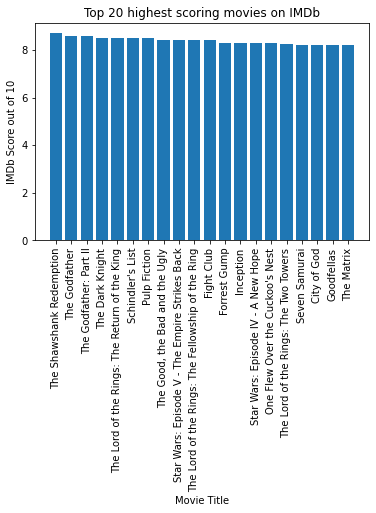

In [12]:
#Constructing a bar chart of the top 20 highest scoring film directors on IMDb and top 20 highest scoring movies on IMDb

IMDB_Score = movies.groupby('director_name').mean().sort_values(by = 'imdb_score', ascending = False)['imdb_score']

plt.bar(IMDB_Score.index[0:20], IMDB_Score[0:20])
plt.xlabel('Director')
plt.ylabel('IMDb Score out of 10')
plt.xticks(rotation = 90)
plt.title('Top 20 highest scoring directors on IMDb')
plt.show()

top20_movies = movies.sort_values(by = 'imdb_score', ascending = False)['movie_title'][0:20]

plt.bar(top20_movies, IMDB_Score[0:20])
plt.xlabel('Movie Title')
plt.ylabel('IMDb Score out of 10')
plt.xticks(rotation = 90)
plt.title('Top 20 highest scoring movies on IMDb')
plt.show()

#All 20 directors and films had scores between 8-8.5

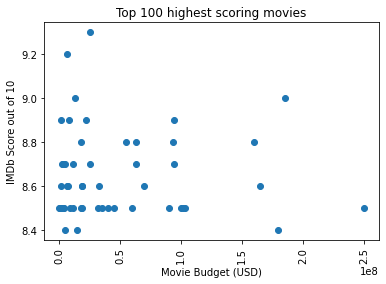

In [13]:
#Plotting IMDb score vs movie budget for the top 50 movies to see if there is a trend 
#between how much is spent on a movie and how well it does among viewers.

#Budgets for the top 50 scoring movies
top50_budgets = movies.sort_values(by = 'imdb_score', ascending = False)['budget'][0:50]

#Scores for the top 50 scoring movies
top50_scores = movies.sort_values(by = 'imdb_score', ascending = False)['imdb_score'][0:50]

plt.scatter(top50_budgets, top50_scores)
plt.xlabel('Movie Budget (USD)')
plt.ylabel('IMDb Score out of 10')
plt.title('Top 100 highest scoring movies')
plt.xticks(rotation = 90)
plt.show()

#It doesn't look like there is a trend between budget and how well a movie performs

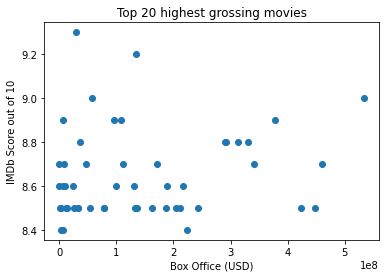

In [14]:
#What about IMDb score vs how much a movie grosses for the top 20 movies?

#Box office for the top 50 movies
top50_gross = movies.sort_values(by = 'imdb_score', ascending = False)['gross'][0:50]

#Scores for the top 50 movies
top50_scores = movies.sort_values(by = 'imdb_score', ascending = False)['imdb_score'][0:50]

plt.scatter(top50_gross, top50_scores)
plt.xlabel('Box Office (USD)')
plt.ylabel('IMDb Score out of 10')
plt.title('Top 20 highest grossing movies')
plt.show()

#Again, there appears to be no trend between how much a film grossed and its IMDb score for the top 50 films

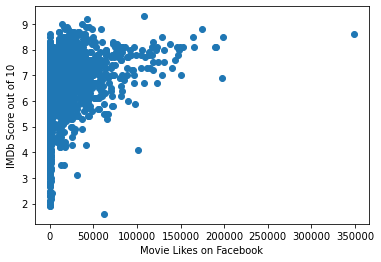

Correlation: 0.2870455013295861


In [15]:
#Plotting IMDb score vs how many likes a movie's Facebook page received.

likes = movies['movie_facebook_likes']
scores = movies['imdb_score']

plt.scatter(likes, scores)
plt.xlabel('Movie Likes on Facebook')
plt.ylabel('IMDb Score out of 10')
plt.show()
print('Correlation: {}'.format(np.corrcoef(likes, scores)[0, 1]))
      
#There appears to be a weak positive correlation between IMDb score and number of Facebook likes

#Movie title will now be deleted as it is not needed for the machine learning analysis.
del movies['movie_title']

In [16]:
#Generating a list of the key predictors to use for the model.

predictors = ['duration', 'director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 
              'cast_total_facebook_likes', 'facenumber_in_poster', 'budget', 'title_year', 'actor_2_facebook_likes',
              'aspect_ratio', 'movie_facebook_likes', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
              'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Musical', 'Mystery', 'Romance', 
              'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'content_rating_G', 'content_rating_GP', 'content_rating_M',
              'content_rating_NC-17', 'content_rating_Not Rated', 'content_rating_PG', 'content_rating_PG-13', 
              'content_rating_Passed', 'content_rating_R', 'content_rating_Unrated', 'content_rating_X']




In [17]:
#Four types of ridge regression models will be built: 

#One using KFCV 
#One using a 80-20 train-test split of the data
#One using KFCV with our dataset one-hot encoded to turn the categorical features into binary features for each element
#One using a 80-20 train-test split of the data using the same one-hot encoded features from Model 3. 
#For all models, root mean squared error (RMSE) will be used as the scoring metric.


#Method 1: Ridge regression with KFCV

#Implementing ridge regression
ridge1 = Ridge(alpha = .001, normalize = True)

#Defining the X (predictors) and y (target) 
X = movies[predictors]
y = movies['imdb_score']

#Scoring the model using a 10-fold cross-validation.
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(ridge1, X , y, scoring = 'neg_mean_squared_error', cv=cv, n_jobs=-1)

#Finding absolute values.
scores = absolute(scores)

In [18]:
#Evaluating the RMSE of the model.
print('RMSE: {} ({})'.format(mean(scores), std(scores)))

RMSE: 0.6965167724434038 (0.07868203232391925)


In [19]:
#Method 2: Ridge regression with an 80-20 train-test splitX

#Splitting the data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45)

In [20]:
#Fitting the model with the training data.
ridge1.fit(X_train, y_train)

Ridge(alpha=0.001, normalize=True)

In [21]:
#Generating numerical predictions.
y_pred = ridge1.predict(X_test)

In [22]:
#Evaluating the RMSE of the model.
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.8291239254188921


In [23]:
#Method 3: Ridge regression with one-hot encoded variables using KFCV

#One-hot encoding the dataframe to turn the categorical columns into binary columns for each element
moviesdf = pd.get_dummies(data = movies, columns = ['director_name', 'actor_2_name', 'actor_1_name', 'actor_3_name', 'country'], drop_first = True)
moviesdf.head()

,genres,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,cast_total_facebook_likes,facenumber_in_poster,movie_imdb_link,budget,...,country_Romania,country_Russia,country_South Africa,country_South Korea,country_Spain,country_Taiwan,country_Thailand,country_UK,country_USA,country_West Germany
0,Action,126,13000,390,920,162831698,2899,0,http://www.imdb.com/title/tt0103776/?ref_=fn_t...,80000000.0,...,0,0,0,0,0,0,0,0,1,0
1,Action,87,29,147,683,1200000,1139,1,http://www.imdb.com/title/tt0104215/?ref_=fn_t...,3000000.0,...,0,0,0,0,0,0,0,0,1,0
2,Action,110,0,7,64,102055,134,0,http://www.imdb.com/title/tt0785035/?ref_=fn_t...,300000000.0,...,0,0,0,0,0,0,1,0,0,0
3,Action,107,561,353,746,15608545,2377,3,http://www.imdb.com/title/tt1258972/?ref_=fn_t...,15000000.0,...,0,0,0,0,0,0,0,0,1,0
4,Action,125,541,409,920,107285004,2699,3,http://www.imdb.com/title/tt0118688/?ref_=fn_t...,125000000.0,...,0,0,0,0,0,0,0,0,1,0


In [24]:
#Cleaning up the data frame with categories we can't use. 
#The link isn't helpful and the genre is too diverse without helpfulness.
del moviesdf['genres']
del moviesdf['movie_imdb_link']
moviesdf.head()

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,cast_total_facebook_likes,facenumber_in_poster,budget,title_year,actor_2_facebook_likes,...,country_Romania,country_Russia,country_South Africa,country_South Korea,country_Spain,country_Taiwan,country_Thailand,country_UK,country_USA,country_West Germany
0,126,13000,390,920,162831698,2899,0,80000000.0,1992,811,...,0,0,0,0,0,0,0,0,1,0
1,87,29,147,683,1200000,1139,1,3000000.0,1993,155,...,0,0,0,0,0,0,0,0,1,0
2,110,0,7,64,102055,134,0,300000000.0,2008,45,...,0,0,0,0,0,0,1,0,0,0
3,107,561,353,746,15608545,2377,3,15000000.0,2012,561,...,0,0,0,0,0,0,0,0,1,0
4,125,541,409,920,107285004,2699,3,125000000.0,1997,890,...,0,0,0,0,0,0,0,0,1,0


In [25]:
#Defining a new X and y.
X = moviesdf[moviesdf.columns]
y = moviesdf['imdb_score']

In [26]:
#Using another 10-fold cross validation.
ridge2 = Ridge()
cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
scores = cross_val_score(ridge2, moviesdf[moviesdf.columns] , movies['imdb_score'], scoring = 'neg_mean_squared_error', cv = cv, n_jobs = -1)
scores = absolute(scores)

In [27]:
#Evaluating the RMSE of the model.
print('RMSE: {} ({})'.format(mean(scores), std(scores)))

RMSE: 0.870428947530296 (0.09502606731002068)


In [28]:
#Method 4: Ridge regression with the one-hot encoded features using an 80-20 train-test split.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 45)

In [29]:
#Fitting the model.
ridge2.fit(X_train,y_train)

Ridge()

In [30]:
#Predicting the model.
y_pred = ridge2.predict(X_test)

In [31]:
#UEvaluating the RMSE of the model.
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 0.9287713414525731


In [32]:
#There were much too many features in the one-hot encoded dataset (moviesdf), so feature selection will be 
#applied to it to see if RMSE can be lowered at all for the models using the one-hot encoded dataset.

#Viewing the head of moviesdf
moviesdf.head()

,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,cast_total_facebook_likes,facenumber_in_poster,budget,title_year,actor_2_facebook_likes,...,country_Romania,country_Russia,country_South Africa,country_South Korea,country_Spain,country_Taiwan,country_Thailand,country_UK,country_USA,country_West Germany
0,126,13000,390,920,162831698,2899,0,80000000.0,1992,811,...,0,0,0,0,0,0,0,0,1,0
1,87,29,147,683,1200000,1139,1,3000000.0,1993,155,...,0,0,0,0,0,0,0,0,1,0
2,110,0,7,64,102055,134,0,300000000.0,2008,45,...,0,0,0,0,0,0,1,0,0,0
3,107,561,353,746,15608545,2377,3,15000000.0,2012,561,...,0,0,0,0,0,0,0,0,1,0
4,125,541,409,920,107285004,2699,3,125000000.0,1997,890,...,0,0,0,0,0,0,0,0,1,0


In [33]:
#Viewing the amount of columns in movies as comparison to moviesdf
movies.columns

Index(['genres', 'director_name', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'actor_1_name', 'cast_total_facebook_likes', 'actor_3_name',
       'facenumber_in_poster', 'movie_imdb_link', 'country', 'budget',
       'title_year', 'actor_2_facebook_likes', 'aspect_ratio',
       'movie_facebook_likes', 'Action', 'Adventure', 'Animation', 'Biography',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Film-Noir', 'History', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 'imdb_score',
       'content_rating_G', 'content_rating_GP', 'content_rating_M',
       'content_rating_NC-17', 'content_rating_Not Rated', 'content_rating_PG',
       'content_rating_PG-13', 'content_rating_Passed', 'content_rating_R',
       'content_rating_Unrated', 'content_rating_X'],
      dtype='object')

In [34]:
#Normalizing the IMDb scores to be between 0 and 1
moviesdf['imdb_score'] = moviesdf['imdb_score']/moviesdf['imdb_score'].max()
moviesdf['imdb_score'].head()

0    0.752688
1    0.548387
2    0.666667
3    0.580645
4    0.397849
Name: imdb_score, dtype: float64

In [35]:
#Creating a list and looping through to format.
moviesdf_list = list(moviesdf.columns)

for x in moviesdf_list:
    x = 'moviesdf["'+x+'"]'
    
len(moviesdf_list)

7944

In [36]:
#Getting the feature weights for the ridge regression model and converting the coefficients to a list.
coef = ridge2.coef_.tolist()
len(coef)

7944

In [37]:
#Displaying the results and formatting it to display next to the name of each categorical value.
for x, z in zip(moviesdf_list, coef):
    z = str(z)
    print(x + ": " + z)

duration: 0.01146565421581986
director_facebook_likes: 3.2167048777176355e-05
actor_3_facebook_likes: 9.706344842025372e-05
actor_1_facebook_likes: 9.403469852864443e-05
gross: -6.184563972055912e-10
cast_total_facebook_likes: -9.15433072123939e-05
facenumber_in_poster: -0.014379136706242576
budget: -1.280568540096283e-09
title_year: -0.016333765053143122
actor_2_facebook_likes: 0.00010757491630419835
aspect_ratio: -0.0001133738420951812
movie_facebook_likes: 1.2371634792174291e-05
Action: -9.61501949487855e-05
Adventure: 0.0007414593496812337
Animation: 0.00025157170796327293
Biography: 0.00015768835223675884
Comedy: -0.0010686915891176057
Crime: -0.0007930748731135576
Documentary: 2.452264342094812e-05
Drama: 0.0002681772517697257
Family: 0.00010579469453167596
Fantasy: 0.00044441729571947333
Film-Noir: 3.331143552915583e-06
History: 0.00011264430717657416
Horror: 0.00028841294148335486
Musical: 4.932525861482891e-05
Mystery: 0.0003373810440575911
Romance: -0.0002972584646280718
Sci-

director_name_John R. Leonetti: 1.610954368435053e-06
director_name_John Sayles: 2.429731469225866e-06
director_name_John Schlesinger: 1.5536433786179572e-06
director_name_John Schultz: -7.954768324887035e-06
director_name_John Singleton: -1.0304825050276813e-05
director_name_John Stainton: 0.0
director_name_John Stockwell: -3.4872853807036192e-06
director_name_John Waters: -3.4252870291297056e-06
director_name_John Wells: 0.0
director_name_John Whitesell: -1.340227349029513e-07
director_name_John Woo: 6.28720383012856e-06
director_name_Johnnie To: 2.3615188526841027e-06
director_name_Johnny Remo: 1.087859096888486e-06
director_name_Jon Amiel: 4.393319200234166e-06
director_name_Jon Avnet: 5.167378164920906e-07
director_name_Jon Favreau: 1.8237655118444622e-05
director_name_Jon Gunn: -4.133292496447454e-06
director_name_Jon Hess: -8.177941293559359e-07
director_name_Jon Hurwitz: -6.964148412329377e-06
director_name_Jon Kasdan: 0.0
director_name_Jon Lucas: 1.4308952926863648e-06
directo

director_name_Terence Young: -2.8839965210579952e-05
director_name_Terrence Malick: 5.3841523604378585e-06
director_name_Terry George: 5.79832979948507e-07
director_name_Terry Gilliam: 6.684128340876368e-06
director_name_Terry Zwigoff: -2.0040409283422996e-06
director_name_Thaddeus O'Sullivan: -3.4896533251666955e-06
director_name_Thea Sharrock: -1.5423630738196274e-07
director_name_Theodore Melfi: -7.576128677673709e-07
director_name_Theodore Witcher: 5.442404620656732e-06
director_name_Thomas Bezucha: 2.1096052646587467e-07
director_name_Thomas Carter: 1.1872053320980412e-06
director_name_Thomas Vinterberg: 2.546224963455412e-06
director_name_Thor Freudenthal: 1.917882837921107e-06
director_name_Ti West: 9.932281473360942e-07
director_name_Tim Blake Nelson: -3.1635475936600365e-06
director_name_Tim Burton: 2.1263959930410377e-06
director_name_Tim Chambers: -2.816195100604579e-06
director_name_Tim Heidecker: -3.950179761364957e-06
director_name_Tim Hill: -4.422284115303306e-06
directo

actor_2_name_Gabriel Damon: 3.3101999267941667e-06
actor_2_name_Gabriel Thomson: 0.0
actor_2_name_Gabrielle Carteris: 0.0
actor_2_name_Gaby Hoffmann: 2.1494732131180087e-06
actor_2_name_Gael Le Cornec: 1.6282805817729209e-06
actor_2_name_Garry Shandling: -3.43448448866792e-06
actor_2_name_Gary Cole: 7.231191479987542e-06
actor_2_name_Gary Lewis: 5.4399139565411715e-06
actor_2_name_Gary Lockwood: 2.3438928088605256e-06
actor_2_name_Gary Oldman: 2.0284428922039695e-05
actor_2_name_Gastón Pauls: -1.4621989783151962e-08
actor_2_name_Gedde Watanabe: -3.730257815242598e-06
actor_2_name_Gena Rowlands: -2.0685003629725946e-06
actor_2_name_Geoff Stults: -3.2521356584166578e-06
actor_2_name_Geoffrey Arend: 3.4669104852103725e-06
actor_2_name_Geoffrey Holder: 0.0
actor_2_name_Geoffrey Palmer: 0.0
actor_2_name_George C. Scott: 1.2521466707079454e-06
actor_2_name_George Carlin: -3.655096941512149e-06
actor_2_name_George Chakiris: 5.579918014293732e-06
actor_2_name_George Hamilton: 5.903128452510431

actor_2_name_Peter Boyle: 6.4134947030639235e-06
actor_2_name_Peter Breck: 4.14527772570777e-06
actor_2_name_Peter Capaldi: -5.360445131406056e-08
actor_2_name_Peter Coyote: -1.2659634036913105e-06
actor_2_name_Peter Cushing: 0.0
actor_2_name_Peter Dante: -1.0677665227818513e-06
actor_2_name_Peter Dinklage: -2.2543296118669262e-05
actor_2_name_Peter Gallagher: 5.659509573364502e-07
actor_2_name_Peter Gerety: 4.542204772450548e-07
actor_2_name_Peter Jason: 4.586851600286946e-06
actor_2_name_Peter Mark Richman: 1.920582063418071e-06
actor_2_name_Peter Marquardt: 1.8538532458257936e-07
actor_2_name_Peter Mensah: 0.0
actor_2_name_Peter Riegert: 0.0
actor_2_name_Peter Stickles: -3.938450570771619e-06
actor_2_name_Peter Vaughan: 2.4319915629423274e-07
actor_2_name_Phil Collins: 1.4915032303206078e-06
actor_2_name_Phil Hartman: -5.265427731960934e-07
actor_2_name_Phil LaMarr: 0.0
actor_2_name_Philip Baker Hall: 5.9932398734143335e-06
actor_2_name_Philip Seymour Hoffman: -2.5566069360686037e-0

actor_1_name_Cameron Monaghan: 2.580340593876705e-07
actor_1_name_Campbell Scott: 1.7609796524920796e-06
actor_1_name_Candice Bergen: 0.0
actor_1_name_Carlos Gallardo: 1.8538532458257936e-07
actor_1_name_Carlos Ponce: -1.4425925717381598e-06
actor_1_name_Carmen Electra: 2.693440184181804e-07
actor_1_name_Carmen Perez: -7.412032119733925e-06
actor_1_name_Carol Ann Susi: 0.0
actor_1_name_Carol Kane: 1.0635502991864592e-06
actor_1_name_Carole Bouquet: -7.993234434271181e-07
actor_1_name_Caroline Dhavernas: 0.0
actor_1_name_Caroline Munro: 1.585205978419372e-07
actor_1_name_Cary-Hiroyuki Tagawa: 9.973598361534155e-06
actor_1_name_Cassie Ventura: 8.354981077481027e-07
actor_1_name_Catalina Sandino Moreno: 2.9678059383547924e-06
actor_1_name_Catherine Deneuve: 8.366525051766698e-07
actor_1_name_Catherine Dyer: 0.0
actor_1_name_Catherine Hicks: 3.7600978598355893e-06
actor_1_name_Catherine Lough Haggquist: 5.304128319696793e-07
actor_1_name_Catherine O'Hara: -1.1334398108062644e-06
actor_1_na

actor_1_name_Martin Dew: 3.3406090261606827e-06
actor_1_name_Martin Kove: 4.241844812375623e-06
actor_1_name_Martin Landau: 5.7098234919583065e-06
actor_1_name_Martin Short: 7.725038001583923e-06
actor_1_name_Martin Starr: -3.4525513823255586e-06
actor_1_name_Mary Elizabeth Mastrantonio: 3.7167840082999506e-06
actor_1_name_Mary Lynn Rajskub: 2.2091910143511313e-06
actor_1_name_Mary McDonnell: 1.0951931493669511e-06
actor_1_name_Mary-Kate Olsen: -1.0014099421981114e-06
actor_1_name_Mathieu Kassovitz: 3.848510197778885e-06
actor_1_name_Matt Bennett: 0.0
actor_1_name_Matt Bomer: 5.153342042712301e-06
actor_1_name_Matt Cohen: -1.0494325404163899e-07
actor_1_name_Matt Damon: 4.523332925732957e-06
actor_1_name_Matt Frewer: -1.9967821627729146e-06
actor_1_name_Matt Lucas: -8.318294216019609e-06
actor_1_name_Matt Price: 1.7296697776198012e-06
actor_1_name_Matt Shively: 4.3474119802626484e-07
actor_1_name_Matt Smith: 4.221184898949426e-06
actor_1_name_Matt Walsh: 3.979689527067083e-06
actor_1_n

actor_3_name_Bernadette Peters: 0.0
actor_3_name_Bernard Hill: -4.162368577999923e-06
actor_3_name_Beth Broderick: 1.5767751396165498e-06
actor_3_name_Beth Grant: 2.640845914003377e-06
actor_3_name_Betsy Russell: 6.035252552557816e-07
actor_3_name_Betty Hutton: 6.605976899842658e-06
actor_3_name_Beverly D'Angelo: -4.87254589834222e-06
actor_3_name_Bianca Kajlich: -6.393571382214531e-06
actor_3_name_Bill Clinton: -1.782312603034675e-07
actor_3_name_Bill Cobbs: 3.967325157450405e-06
actor_3_name_Bill Erwin: 3.3101999267941667e-06
actor_3_name_Bill Fagerbakke: 6.433664883237444e-06
actor_3_name_Bill Hunter: 2.7613951781393935e-08
actor_3_name_Bill Irwin: 1.221405791936738e-06
actor_3_name_Bill Johnson: 2.244252173442956e-06
actor_3_name_Bill Melendez: -3.8165069464705245e-06
actor_3_name_Bill Murray: 3.7172829279861793e-06
actor_3_name_Bill Nunn: 5.2231550813471025e-06
actor_3_name_Billie Burke: 2.6782330687073836e-06
actor_3_name_Billie Whitelaw: 1.5156794817524127e-06
actor_3_name_Billy

actor_3_name_Imelda Staunton: 1.8958920902016736e-07
actor_3_name_Ingrid Bolsø Berdal: 5.602930347329439e-06
actor_3_name_Ion Overman: -3.343097026405725e-06
actor_3_name_Ione Skye: -5.755958503122558e-07
actor_3_name_Irene Bedard: -5.001013251674661e-06
actor_3_name_Isabella Rossellini: 3.7291344610446297e-06
actor_3_name_Isabelle Adjani: 1.0635502991864592e-06
actor_3_name_Isabelle Huppert: -7.787745902042123e-06
actor_3_name_Isabelle Nanty: 3.848510197778885e-06
actor_3_name_Isabelle Nélisse: 7.279229658432463e-07
actor_3_name_Isaiah Washington: -8.450837715979699e-07
actor_3_name_Isiah Thomas: -2.1824095489657934e-07
actor_3_name_Ivan Sergei: 8.165691977829443e-07
actor_3_name_Ivana Milicevic: -6.681627056655631e-07
actor_3_name_Izabella Miko: -1.4394697142144727e-05
actor_3_name_Izabella Scorupco: 2.6955341494157064e-06
actor_3_name_J. Smith-Cameron: -4.922522271442826e-06
actor_3_name_J.B. Smoove: -1.821647650244343e-05
actor_3_name_J.J. Cohen: 9.535945473777142e-08
actor_3_name_

actor_3_name_Natasha Henstridge: -8.490370097896326e-06
actor_3_name_Natasha Lyonne: -1.6569695707508187e-05
actor_3_name_Natasha Richardson: -3.1200434181569674e-06
actor_3_name_Nathan Lane: 2.0424435032098504e-06
actor_3_name_Nathaniel Parker: -2.293605108307078e-06
actor_3_name_Ned Beatty: 1.3031768868150124e-06
actor_3_name_Ned Bellamy: -2.403519447681087e-06
actor_3_name_Neil Armstrong: 0.0
actor_3_name_Neil Flynn: -3.260367347988197e-06
actor_3_name_Neil Maskell: 5.057827734142863e-06
actor_3_name_Nellie McKay: 1.3739422917432922e-06
actor_3_name_Nellie Sciutto: -4.2968244602195737e-07
actor_3_name_Nels Lennarson: 1.4144662272890258e-06
actor_3_name_Nia Long: 0.0
actor_3_name_Nia Vardalos: 1.621638091303616e-06
actor_3_name_Niall Horan: -1.4574529045134525e-05
actor_3_name_Nichelle Nichols: 3.5991756527765454e-06
actor_3_name_Nicholas Bell: 5.845511618808389e-06
actor_3_name_Nicholas Braun: -6.524499084958539e-06
actor_3_name_Nicholas Elia: 5.005381239911787e-06
actor_3_name_Nich

actor_3_name_Zinedine Soualem: 1.8627028256621713e-06
actor_3_name_Zoe Kazan: 0.0
actor_3_name_Zoe Levin: 0.0
actor_3_name_Zooey Deschanel: -4.845298392852606e-05
actor_3_name_Zoë Bell: 1.188083801512073e-05
actor_3_name_Zoë Kravitz: 0.0
actor_3_name_Zoë Poledouris: 7.918560399458491e-06
actor_3_name_Óscar Jaenada: 1.1277325490235298e-06
country_Argentina: 4.345144623215049e-09
country_Aruba: 4.685248734356295e-06
country_Australia: 1.7622827306544765e-05
country_Belgium: 3.209752632118851e-06
country_Brazil: 2.690675506063058e-06
country_Canada: 4.756264573118752e-05
country_Chile: -8.100527878435476e-06
country_China: -2.1738255546966723e-05
country_Colombia: 2.9678059383547924e-06
country_Czech Republic: 2.3545792607502014e-06
country_Denmark: 8.045444791397261e-06
country_Finland: -2.7547141319381785e-06
country_France: 8.351697983323246e-05
country_Georgia: -9.53451046970956e-06
country_Germany: -5.964578730172585e-06
country_Greece: 0.0
country_Hong Kong: 1.8465820378222125e-05
c

In [38]:
#As expected, there are much too many coefficients. The feature selection will be done using a method devised from scratch.
max_val = max(coef)
print(max_val)

0.01146565421581986


In [62]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 50)
principalComponents = pca.fit_transform(X)
principalComponents = pd.DataFrame(principalComponents)
principalComponents

important_features = []
for x, f_name in zip(coef, moviesdf.columns):
    if x > max_val/150:
        important_features.append(f_name)

important_features

['title_year',
 'actor_2_facebook_likes',
 'Adventure',
 'Drama',
 'Fantasy',
 'History',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'imdb_score',
 'content_rating_G',
 'content_rating_GP',
 'content_rating_Not Rated',
 'content_rating_Passed',
 'director_name_Abel Ferrara']

In [63]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(principalComponents, moviesdf['imdb_score'], test_size = 0.2)

ridge_model = Ridge(alpha = .001)
ridge_model.fit(X_train2, y_train2)
y_pred2 = ridge_model.predict(X_test2)
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred2))))


RMSE: 0.1546207554035499


In [64]:
coef = ridge_model.coef_.tolist()
print(len(coef))

50


In [66]:
for x, z in zip(important_features, coef):
    print(x, z)


title_year 7.675360025706362e-11
actor_2_facebook_likes -3.477561879454174e-10
Adventure 5.162186347292388e-07
Drama 1.1593086873642222e-06
Fantasy -6.390154973523045e-07
History 5.2233755561374375e-06
Sci-Fi 4.452717673328804e-06
Sport -2.4783407437033303e-05
Thriller 0.0015188307315147959
War 0.0017342678716617847
imdb_score -0.0040189108681450625
content_rating_G -0.10095233160707084
content_rating_GP -0.006303763090249452
content_rating_Not Rated 0.01838842607414019
content_rating_Passed -0.01820045079867079
director_name_Abel Ferrara -0.020532419909042456
